In [316]:
import re
import pandas as pd

pd.set_option('display.max_columns', None)

In [183]:
df = pd.read_csv('chess_games.csv', nrows=1000000,
                usecols=['Event', 'Result', 'UTCDate', 'Opening', 'Termination', 'AN']) # chunksize=100000, index_col=''

In [184]:
df.head(3)

,Event,Result,UTCDate,Opening,Termination,AN
0,Classical,1-0,2016.06.30,Slav Defense,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...
1,Blitz,0-1,2016.06.30,King's Pawn Opening: 2.b3,Normal,1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...
2,Blitz tournament,1-0,2016.06.30,Scandinavian Defense: Mieses-Kotroc Variation,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Bg4 4. Be2 Nf6 5....


In [185]:
filt = (df['Result'] != '*') & (df['Termination'] != 'Abandoned') & (df['Termination'] != 'Rules infraction')
df = df[filt]

In [186]:
df['UTCDate'] = pd.to_datetime(df['UTCDate'])

In [187]:
df['Tournament'] = df['Event'].str.contains('tournament')

In [188]:
df['Event'].value_counts()

 Blitz                    374663
 Classical                241289
 Bullet                   196192
 Bullet tournament         79983
 Blitz tournament          74760
 Classical tournament      26900
 Correspondence             3816
Classical                      4
Blitz                          2
Blitz tournament               1
Bullet                         1
Name: Event, dtype: int64

In [189]:
df['Event'].unique()

array([' Classical ', ' Blitz ', ' Blitz tournament ', ' Correspondence ',
       ' Classical tournament ', ' Bullet tournament ', ' Bullet ',
       'Blitz tournament ', 'Bullet ', 'Classical ', 'Blitz '],
      dtype=object)

In [190]:
df['Event'] = df['Event'].map({' Classical ': 'Classical',
                               ' Blitz ': 'Blitz',
                               ' Blitz tournament ': 'Blitz',
                               ' Correspondence ': 'Classical',
                               ' Classical tournament ': 'Classical',
                               ' Bullet tournament ': 'Bullet',
                               ' Bullet ': 'Bullet',
                               'Blitz tournament ': 'Blitz',
                               'Bullet ': 'Bullet',
                               'Classical ': 'Classical',
                               'Blitz ': 'Blitz'
                               })

In [191]:
df['Event'].value_counts()

Blitz        449426
Bullet       276176
Classical    272009
Name: Event, dtype: int64

In [192]:
df.head()

,Event,Result,UTCDate,Opening,Termination,AN,Tournament
0,Classical,1-0,2016-06-30,Slav Defense,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...,False
1,Blitz,0-1,2016-06-30,King's Pawn Opening: 2.b3,Normal,1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...,False
2,Blitz,1-0,2016-06-30,Scandinavian Defense: Mieses-Kotroc Variation,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Bg4 4. Be2 Nf6 5....,True
3,Classical,1-0,2016-06-30,Van't Kruijs Opening,Normal,1. e3 Nf6 2. Bc4 d6 3. e4 e6 4. Nf3 Nxe4 5. Nd...,False
4,Blitz,0-1,2016-06-30,"Sicilian Defense: Najdorf, Lipnitsky Attack",Time forfeit,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...,True


In [193]:
df['Opening'].value_counts()

Van't Kruijs Opening                                              21159
Scandinavian Defense: Mieses-Kotroc Variation                     18487
Modern Defense                                                    16940
Horwitz Defense                                                   15408
Sicilian Defense                                                  14136
                                                                  ...  
Queen's Indian, Averbakh Variation                                    1
Russian Game: Modern Attack, Murrey Variation                         1
Four Knights Game: Spanish Variation, Symmetrical Variation #2        1
Ruy Lopez: Classical Defense: Zaitsev Variation                       1
Vienna Game: Mieses Variation, Erben Gambit                           1
Name: Opening, Length: 2707, dtype: int64

In [194]:
df_open = df['Opening'].value_counts().rename_axis('unique_values').reset_index(name='counts')

In [195]:
df_open[df_open['counts']>1500]
#df_open.head(100)

,unique_values,counts
0,Van't Kruijs Opening,21159
1,Scandinavian Defense: Mieses-Kotroc Variation,18487
2,Modern Defense,16940
3,Horwitz Defense,15408
4,Sicilian Defense,14136
...,...,...
146,Slav Defense: Three Knights Variation,1557
147,Ruy Lopez: Classical Variation,1544
148,"Nimzowitsch Defense: Scandinavian Variation, A...",1526
149,Petrov's Defense,1519


In [140]:
# value_counts = df.stack().value_counts() # Entire DataFrame 
# to_remove = value_counts[value_counts <= 1500].index
# df.replace(to_remove, np.nan, inplace=True)

(2707, 2)

In [208]:
vc = df['Opening'].value_counts()
vals_to_remove = vc[vc <= 1500].index.values
df['Opening'].loc[df['Opening'].isin(vals_to_remove)] = '111'

C:\Users\PFIQ3000\AppData\Local\Temp\ipykernel_5420\304048592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Opening'].loc[df['Opening'].isin(vals_to_remove)] = '111'


In [209]:
filt = df['Opening'] != '111'
df = df[filt]

In [365]:
df = df.reset_index()

In [372]:
def get_moves_as_list(cell: int) -> list:
    ori_list = []
    ori_list.append(df.loc[cell, 'AN'])
    sep_num = 2
    while True:
        separator = str(sep_num)+'.'
        if separator in ori_list[-1]:
            ori_list = ori_list[0:-1] + ori_list[-1].split(' '+separator) # concatenate all previous moves and remainder
            ori_list[-1] = separator + ori_list[-1]
            sep_num+=1
        else:
            ori_list[-1] = re.sub(' 1-0', '', ori_list[-1])
            ori_list[-1] = re.sub(' 0-1', '', ori_list[-1])
            ori_list[-1] = re.sub(' 1/2-1/2', '', ori_list[-1])
    return ori_list

In [296]:
for row in range(df.shape[0]):
    if type(df.loc[row, 'AN']) == str:
        df.loc[row, 'AN'] = get_moves_as_list(row)
    else:
        print(f'Value is a {type(df.loc[0, 'AN'])}')

['1. d4 d5',
 '2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e4 6. Ne5 cxd5 7. Qa4+ Bd7 8. Nxd7 Nxd7 9. Nc3 Nf6 10. Qb3 Be7 11. Nxd5 Qa5+ 12. Nc3 O-O 13. Be2 b5 14. O-O Rad8 15. Bd2 Qc7 16. Rac1 Qd6 17. Qc2 Qe6 18. Nb1 Bd6 19. a3 Nb6 20. Qc6 Nfd5 21. Ba5 Rc8 22. Qb7 Qh6 23. h3 Nc4 24. Bxc4 bxc4 25. Qxd5 Rfd8 26. Qxe4 Rd7 27. Bc3 Re7 28. Qf3 Re6 29. Nd2 Rf6 30. Qg4 Re8 31. Ne4 Rg6 32. Qd7 Rf8 33. Nxd6 Rxd6 34. Qc7 Rg6 35. Qh2 Re8 36. d5 f6 37. d6 Rd8 38. Rfd1 1-0']

In [369]:
for row in range(df.shape[0]):
    if type(df.loc[row, 'AN']):
        print(df.loc[row, 'AN'])

Hi
1. Nf3 Nc6 2. e4 e5 3. Bb5 d6 4. O-O Bd7 5. Nc3 Nf6 6. b3 a6 7. Be2 Qe7 8. Bb2 O-O-O 9. d4 exd4 10. Nxd4 Nxe4 11. Nxc6 Bxc6 12. Nxe4 Bxe4 13. Re1 Re8 14. Bg4+ Kb8 15. f3 h5 16. Rxe4 Qxe4 17. fxe4 hxg4 18. Qxg4 g6 19. Rf1 Rh7 20. Bf6 Re6 21. e5 dxe5 22. Rd1 Bc5+ 23. Kh1 Rxf6 24. Rd8+ Ka7 25. b4 Rf1# 0-1
Hi
1. e4 e5 0-1


<Axes: >

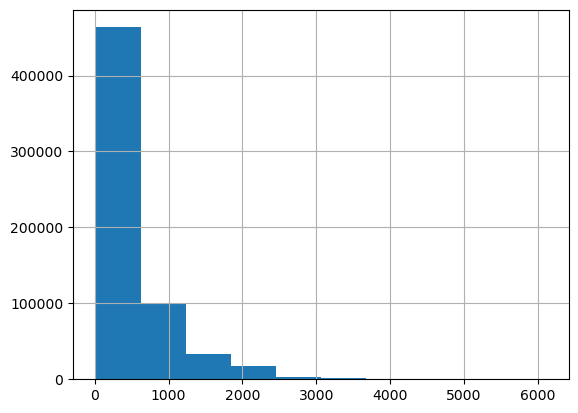

In [378]:
df["AN"].str.len().hist()

In [383]:
filt = df["AN"].str.len() == 6119
df.loc[52412, 'AN']

'1. e4 { [%eval 0.26] } 1... c5 { [%eval 0.29] } 2. Nf3 { [%eval 0.29] } 2... Nc6 { [%eval 0.43] } 3. Bb5 { [%eval 0.34] } 3... e6 { [%eval 0.31] } 4. O-O { [%eval 0.35] } 4... Be7 { [%eval 0.32] } 5. d4 { [%eval 0.12] } 5... cxd4 { [%eval 0.16] } 6. Nxd4 { [%eval 0.08] } 6... Nf6 { [%eval 0.14] } 7. Nc3 { [%eval 0.09] } 7... O-O { [%eval 0.06] } 8. Be2 { [%eval -0.03] } 8... d5 { [%eval 0.17] } 9. exd5 { [%eval 0.15] } 9... exd5 { [%eval 0.1] } 10. Be3 { [%eval 0.12] } 10... a6 { [%eval 0.1] } 11. Re1 { [%eval 0.1] } 11... Qc7 { [%eval 0.32] } 12. h3 { [%eval 0.07] } 12... Rd8 { [%eval 0.31] } 13. a3 { [%eval 0.04] } 13... Ne5 { [%eval 0.41] } 14. Bf4 { [%eval 0.41] } 14... Bd6 { [%eval 0.47] } 15. Bg3 { [%eval 0.18] } 15... Nc4 { [%eval 0.51] } 16. Bxd6 { [%eval 0.09] } 16... Rxd6 { [%eval 0.14] } 17. Ndb5?! { [%eval -0.6] } 17... axb5 { [%eval -0.6] } 18. Nxb5 { [%eval -0.58] } 18... Qd7 { [%eval -0.77] } 19. Bxc4 { [%eval -0.76] } 19... Rb6 { [%eval -0.73] } 20. Qd4 { [%eval -0.73]